# SETTING UP

### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler #to scale data 
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Importing data

In [4]:
dataset_dir = '/kaggle/input/training-datasethomework2/training_dataset_homework2'

In [5]:
X_train = np.load(os.path.join(dataset_dir,'x_train.npy'))
Y_train = np.load(os.path.join(dataset_dir,'y_train.npy'))

In [6]:
classes_dict = {0: "Wish",
          1: "Another",
          2: "Comfortably",
          3: "Money",
          4: "Breathe",
          5: "Time",
          6: "Brain",
          7: "Echoes",
          8: "Wearing",
          9: "Sorrow",
          10: "Hey", 
          11: "Shine"
          }

classes_dict.values()

classes_labels = list(classes_dict.values())

Y_train_labels=[]

for i in Y_train:
    Y_train_labels.append(classes_labels[Y_train[i]])

In [ ]:
feat_dict = {0: 'FEAT_1',
               1: 'FEAT_2',
               2: 'FEAT_3',
               3: 'FEAT_4',
               4: 'FEAT_5',
               5: 'FEAT_6'}

feat_labels = list(feat_dict.values())

### Splitting data

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, 
                                                  test_size = 0.2, 
                                                  random_state = seed,
                                                  stratify = Y_train)

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

print('Shapes:')
print('x_train: ', x_train.shape)
print('x_val: ', x_val.shape)
print('y_train: ', y_train.shape)
print('y_val: ', y_val.shape)

Shapes:
x_train:  (1943, 36, 6)
x_val:  (486, 36, 6)
y_train:  (1943, 12)
y_val:  (486, 12)


# DATA PREPROCESSING

Insert a preprocessing routine from the notebook HW2_preprocessing.ipynb 

# BUILD AND TRAIN 

In [59]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 256
epochs = 20

### Importing pretrained models

In [ ]:
model_1 = tfk.models.load_model('') #insert path
model_1._name = 'model_1'

model_2 = tfk.models.load_model('') #insert path
model_2._name = 'model_2'

In [ ]:
#freeze layers
for layer in model_1.layers:
    layer.trainable = False
    
for layer in model_2.layers:
    layer.trainable = False

### Build and train the ensemble model

In [ ]:
inputs = model_1.input

m_1 = model_1(inputs)

m_2 = model_2(inputs)

outputs = tfkl.concatenate([m_1, m_2])

dense = tfkl.Dense(classes, activation = 'softmax',  
        kernel_initializer = tfk.initializers.GlorotUniform(seed)) (outputs)

# Connect input and output through the Model class
ensemble_model = tfk.Model(inputs=inputs, outputs=dense, name='ensemble_method')

# Compile the model
ensemble_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(lr=1e-3), metrics='accuracy')
ensemble_model.summary()

tf.keras.utils.plot_model(ensemble_model, show_shapes=True)

In [ ]:
#callbacks
callbacks = []

#learning_rate_reduction = tfk.callbacks.LearningRateScheduler(scheduler,verbose=1)   
#callbacks.append(learning_rate_reduction)

early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=5,restore_best_weights=True)
callbacks.append(early_stopping)

In [ ]:
#train the model
history = ensemble_model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    callbacks = callbacks
).history

### Performance

In [51]:
# Predict the test set with the LSTM
predictions = model.predict(x_val)
predictions.shape

(486, 12)

Accuracy: 0.6091
Precision: 0.5549
Recall: 0.4596
F1: 0.4827


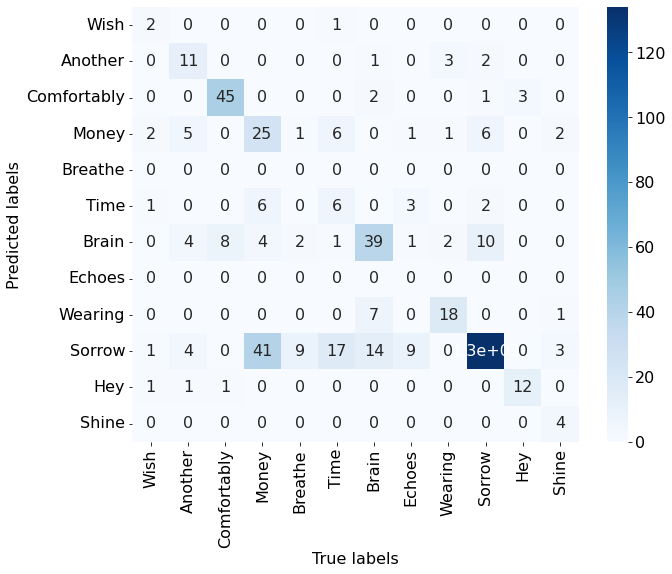

              precision    recall  f1-score   support

        Wish       0.67      0.29      0.40         7
     Another       0.65      0.44      0.52        25
 Comfortably       0.88      0.83      0.86        54
       Money       0.51      0.33      0.40        76
     Breathe       0.00      0.00      0.00        12
        Time       0.33      0.19      0.24        31
       Brain       0.55      0.62      0.58        63
      Echoes       0.00      0.00      0.00        14
     Wearing       0.69      0.75      0.72        24
      Sorrow       0.58      0.86      0.69       155
         Hey       0.80      0.80      0.80        15
       Shine       1.00      0.40      0.57        10

    accuracy                           0.61       486
   macro avg       0.55      0.46      0.48       486
weighted avg       0.58      0.61      0.57       486



In [52]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(classes_dict.values()), yticklabels=list(classes_dict.values()), annot = True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#Print the classification report
print(classification_report(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), target_names=classes_dict.values()))